In [6]:
import numpy as np
import scipy.integrate
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
import copy

from miou.metrics import miou
from miou.metrics.iou import IoU
from miou.utils.mask_loader import load_mask
from miou.utils.segmentation import GridBasedSegmentation
from scipy.stats import linregress
from miou.edge_detection import sobel
from scipy.integrate import trapezoid, simpson
import matplotlib.pyplot as plt 


In [7]:
def pre_process_masks(mask1, mask2, scale):  # This is the function s in the paper
    preprocessor1 = GridBasedSegmentation(mask1, scale)
    s1 = preprocessor1.segmentize()
    preprocessor2 = GridBasedSegmentation(mask2, scale)
    s2 = preprocessor2.segmentize()

    return s1, s2

In [8]:
def calculate_bce_with_logits(gt, prediction, scale):
    loss = nn.BCEWithLogitsLoss()
    l = loss(prediction, gt)
    return l

In [9]:
def calculate_bce(gt, prediction, scale):
    loss = nn.BCELoss()
    l = loss(prediction, gt)
    return l

In [10]:
def calculate_area(distances, scales):
    b = copy.deepcopy(scales).reshape((-1, 1))
    normalized_scales = MinMaxScaler().fit_transform(b)
    normalized_scales = normalized_scales.reshape(-1)
    area = simpson(distances, normalized_scales)
    return area

In [11]:
def normalize_distance(distance):
    l = torch.exp(-distance)
    return l

In [12]:
gt = load_mask("./test_images/test_segm_input_B/mask1.png")
img2 = load_mask("./test_images/test_segm_input_B/mask2.png")
img3 = load_mask("./test_images/test_segm_input_B/mask3.png")
# img2 = load_mask("./test_images/test_segm_input_B/mask1.png")
masks = [gt, img2, img3]

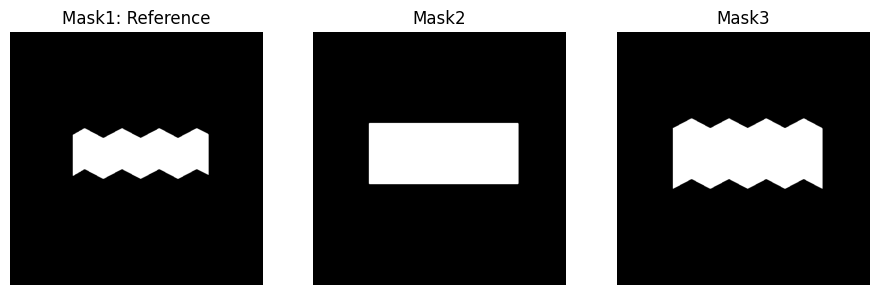

In [13]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [14]:
scales = np.power(2, np.linspace(0, 9, num=10, dtype=int))

In [15]:
def MCE(gt, img2, detect_edges = True):

    distances = []
    box_counting_m1 = []
    box_counting_m2 = []
    box_counting_distance = []
    
    if detect_edges:
        gt = sobel.get_edges(gt)
        img2 = sobel.get_edges(img2)
        
    for scale in scales:
        s_gt, s_img2 = pre_process_masks(gt, img2, scale)
        # distance = calculate_ce(torch.from_numpy(s_gt.astype(float)), torch.from_numpy(s_img2.astype(float)), scale)
        # distance = calculate_ce(
        #     torch.tensor(box_counting_m1[-1], dtype=torch.float),
        #     torch.tensor(box_counting_m2[-1], dtype=torch.float),
        #     scale)
        # distance = calculate_bce_with_logits(
        #     torch.tensor(s_gt, dtype=torch.float),
        #     torch.tensor(s_img2, dtype=torch.float),
        #     scale)
        distance = calculate_bce(
            torch.tensor(s_gt, dtype=torch.float),
            torch.tensor(s_img2, dtype=torch.float),
            scale)
        print(f"distance: {distance}")
        distance = normalize_distance(distance)
        distances.append(distance)

    print(f"distances: {distances}")
    mce = calculate_area(distances, scales)
    
    print(f"mce: {mce}")
    return mce



In [16]:
mce_gt_img2 = MCE(gt, img2)

distance: 1.40838623046875
distance: 2.34832763671875
distance: 4.23583984375
distance: 7.275390625
distance: 9.66796875
distance: 12.5
distance: 15.625
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.2445), tensor(0.0955), tensor(0.0145), tensor(0.0007), tensor(6.3278e-05), tensor(3.7267e-06), tensor(1.6374e-07), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.8771670211379198


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [17]:
mce_gt_img3 = MCE(gt, img3)

distance: 1.6387939453125
distance: 2.4627685546875
distance: 4.119873046875
distance: 7.51953125
distance: 9.5703125
distance: 10.546875
distance: 9.375
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.1942), tensor(0.0852), tensor(0.0162), tensor(0.0005), tensor(6.9770e-05), tensor(2.6275e-05), tensor(8.4818e-05), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.8771251206156365


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [18]:
mce_gt_img2

0.8771670211379198

In [19]:
mce_gt_img3

0.8771251206156365

In [20]:
mce_gt_img2_no_edge = MCE(gt, img2, detect_edges = False)

distance: 5.6194305419921875
distance: 5.4779052734375
distance: 5.029296875
distance: 4.5654296875
distance: 4.78515625
distance: 4.296875
distance: 9.375
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.0036), tensor(0.0042), tensor(0.0065), tensor(0.0104), tensor(0.0084), tensor(0.0136), tensor(8.4818e-05), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.8779335227685479


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [21]:
mce_gt_img3_no_edge = MCE(gt, img3, detect_edges = False)

distance: 5.5080413818359375
distance: 5.5450439453125
distance: 5.46875
distance: 5.2490234375
distance: 4.8828125
distance: 4.296875
distance: 9.375
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.0041), tensor(0.0039), tensor(0.0042), tensor(0.0053), tensor(0.0076), tensor(0.0136), tensor(8.4818e-05), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.8778335973439868


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [22]:
print(mce_gt_img2_no_edge)
print(mce_gt_img2)

0.8779335227685479
0.8771670211379198


In [23]:
print(mce_gt_img3_no_edge)
print(mce_gt_img3)

0.8778335973439868
0.8771251206156365


In [24]:
mce_gt_gt = MCE(gt, gt, detect_edges = False)

distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 1.0


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [25]:
# Example2: Solar filament

In [26]:
mask1 = load_mask('./test_images/test_segm_input_Z2/mask1.png')
mask2 = load_mask('./test_images/test_segm_input_Z2/mask2.png')
mask3 = load_mask('./test_images/test_segm_input_Z2/mask3.png')
masks = [mask1, mask2, mask3]

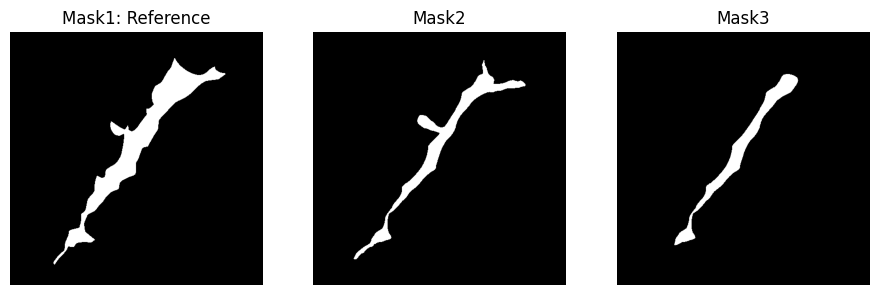

In [27]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [28]:
mce_f1_f2 = MCE(mask1, mask2)

distance: 2.391815185546875
distance: 3.40118408203125
distance: 5.023193359375
distance: 6.54296875
distance: 6.640625
distance: 4.6875
distance: 1.5625
distance: 6.25
distance: 25.0
distance: 0.0
distances: [tensor(0.0915), tensor(0.0333), tensor(0.0066), tensor(0.0014), tensor(0.0013), tensor(0.0092), tensor(0.2096), tensor(0.0019), tensor(1.3888e-11), tensor(1.)]
mce: 0.20091472371931593


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [29]:
mce_f1_f2_no_edge = MCE(mask1, mask2, detect_edges=False)

distance: 4.2102813720703125
distance: 4.30908203125
distance: 4.376220703125
distance: 4.345703125
distance: 4.6875
distance: 4.6875
distance: 1.5625
distance: 6.25
distance: 25.0
distance: 0.0
distances: [tensor(0.0148), tensor(0.0134), tensor(0.0126), tensor(0.0130), tensor(0.0092), tensor(0.0092), tensor(0.2096), tensor(0.0019), tensor(1.3888e-11), tensor(1.)]
mce: 0.20108528007793355


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [30]:
mce_f1_f3 = MCE(mask1, mask3)

distance: 2.1953582763671875
distance: 3.179931640625
distance: 4.8583984375
distance: 6.7138671875
distance: 7.6171875
distance: 7.03125
distance: 7.8125
distance: 12.5
distance: 25.0
distance: 0.0
distances: [tensor(0.1113), tensor(0.0416), tensor(0.0078), tensor(0.0012), tensor(0.0005), tensor(0.0009), tensor(0.0004), tensor(3.7267e-06), tensor(1.3888e-11), tensor(1.)]
mce: 0.19511614753768763


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [31]:
mce_f1_f3_no_edge = MCE(mask1, mask3, detect_edges=False)

distance: 3.806304931640625
distance: 3.92913818359375
distance: 4.13818359375
distance: 4.541015625
distance: 5.46875
distance: 6.640625
distance: 7.8125
distance: 12.5
distance: 25.0
distance: 0.0
distances: [tensor(0.0222), tensor(0.0197), tensor(0.0160), tensor(0.0107), tensor(0.0042), tensor(0.0013), tensor(0.0004), tensor(3.7267e-06), tensor(1.3888e-11), tensor(1.)]
mce: 0.19524965240823033


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [32]:
mce_f1_f1 = MCE(mask1, mask1)

distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 1.0


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [33]:
mce_f1_f1_no_edge = MCE(mask1, mask1, detect_edges=False)

distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 1.0


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [34]:
miou_obj = miou.MIoU(scales, edge_only=True)
miou_obj_no_edge = miou.MIoU(scales, edge_only=False)

In [35]:
print('-----------------------resuts-----------------------')
print('=========example1: gt, img2===============')
print(f'mce: {mce_gt_img2}')
print(f'mce without edge detection: {mce_gt_img2_no_edge}')
print(f'MioU:{miou_obj.measure(gt, img2)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(gt, img2)}')
print('=========example1: gt, img3===============')
print(f'mce: {mce_gt_img3}')
print(f'mce without edge detection: {mce_gt_img3_no_edge}')
print(f'MioU:{miou_obj.measure(gt, img3)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(gt, img3)}')
print('=========example2: mask1, mask1===============')
print(f'mce: {mce_f1_f1}')
print(f'mce without edge detection: {mce_f1_f1_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask1)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask1)}')
print('=========example2: mask1, mask2===============')
print(f'mce: {mce_f1_f2}')
print(f'mce without edge detection: {mce_f1_f2_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask2)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask2)}')
print('=========example2: mask1, mask3===============')
print(f'mce: {mce_f1_f3}')
print(f'mce without edge detection: {mce_f1_f3_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask3)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask3)}')

-----------------------resuts-----------------------
=========example1: gt, img2===============
mce: 0.8771670211379198
mce without edge detection: 0.8779335227685479
MioU:0.43646410763160254
MioU without edge detection:1.0
=========example1: gt, img3===============
mce: 0.8771251206156365
mce without edge detection: 0.8778335973439868
MioU:0.501124778635557
MioU without edge detection:1.0
=========example2: mask1, mask1===============
mce: 1.0
mce without edge detection: 1.0
MioU:1.0
MioU without edge detection:1.0
=========example2: mask1, mask2===============
mce: 0.20091472371931593
mce without edge detection: 0.20108528007793355
MioU:0.5931655063539093
MioU without edge detection:0.7207830905399536
=========example2: mask1, mask3===============
mce: 0.19511614753768763
mce without edge detection: 0.19524965240823033
MioU:0.4809574598992603
MioU without edge detection:0.6280702813082769


In [36]:
# Example3: Leaf Example

In [37]:
mask1 = load_mask('./test_images/test_segm_input_Z3/mask1.png')
mask2 = load_mask('./test_images/test_segm_input_Z3/mask2.png')
mask3 = load_mask('./test_images/test_segm_input_Z3/mask3.png')
masks = [mask1, mask2, mask3]

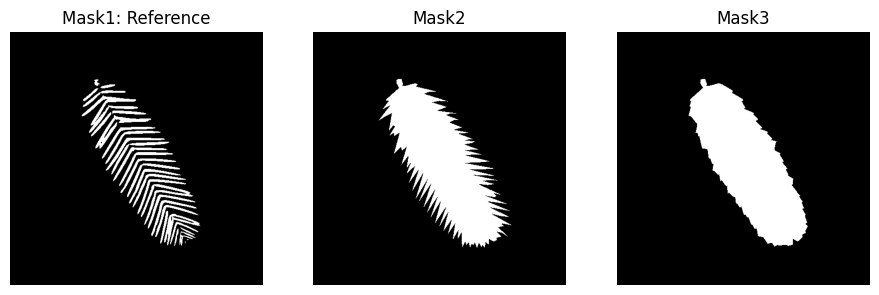

In [38]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [39]:
mce_L1_L1 = MCE(mask1, mask1)

distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 1.0


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [40]:
mce_L1_L1_no_edge = MCE(mask1, mask1, detect_edges=False)

distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 1.0


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [41]:
mce_L1_L2 = MCE(mask1, mask2)

distance: 8.454513549804688
distance: 11.5020751953125
distance: 14.239501953125
distance: 13.9892578125
distance: 12.40234375
distance: 8.59375
distance: 3.125
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.0002), tensor(1.0109e-05), tensor(6.5443e-07), tensor(8.4051e-07), tensor(4.1089e-06), tensor(0.0002), tensor(0.0439), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7072860454468101


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [42]:
mce_L1_L2_no_edge = MCE(mask1, mask2, detect_edges=False)

distance: 8.385848999023438
distance: 7.4127197265625
distance: 5.37109375
distance: 3.7353515625
distance: 4.1015625
distance: 3.515625
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.0002), tensor(0.0006), tensor(0.0046), tensor(0.0239), tensor(0.0165), tensor(0.0297), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7090787663210285


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [43]:
mce_L1_L3 = MCE(mask1, mask3)

distance: 7.2635650634765625
distance: 10.302734375
distance: 13.4765625
distance: 13.8916015625
distance: 12.109375
distance: 8.984375
distance: 4.6875
distance: 6.25
distance: 0.0
distance: 0.0
distances: [tensor(0.0007), tensor(3.3541e-05), tensor(1.4035e-06), tensor(9.2673e-07), tensor(5.5076e-06), tensor(0.0001), tensor(0.0092), tensor(0.0019), tensor(1.), tensor(1.)]
mce: 0.7067948790052484


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [44]:
mce_L1_L3_no_edge = MCE(mask1, mask3, detect_edges=False)

distance: 8.443832397460938
distance: 6.94122314453125
distance: 4.010009765625
distance: 1.46484375
distance: 1.3671875
distance: 1.953125
distance: 1.5625
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.0002), tensor(0.0010), tensor(0.0181), tensor(0.2311), tensor(0.2548), tensor(0.1418), tensor(0.2096), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.8972240570594486


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [45]:
print('-----------------------resuts-----------------------')
print('=========example3: gt, gt===============')
print(f'mce: {mce_L1_L1}')
print(f'mce without edge detection: {mce_L1_L1_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask1)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask1)}')
print('=========example3: gt, mask2===============')
print(f'mce: {mce_L1_L2}')
print(f'mce without edge detection: {mce_L1_L2_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask2)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask2)}')
print('=========example2: mask1, mask3===============')
print(f'mce: {mce_L1_L3}')
print(f'mce without edge detection: {mce_L1_L3_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask3)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask3)}')

-----------------------resuts-----------------------
=========example3: gt, gt===============
mce: 1.0
mce without edge detection: 1.0
MioU:1.0
MioU without edge detection:1.0
=========example3: gt, mask2===============
mce: 0.7072860454468101
mce without edge detection: 0.7090787663210285
MioU:0.6129562121025678
MioU without edge detection:0.9992155600159403
=========example2: mask1, mask3===============
mce: 0.7067948790052484
mce without edge detection: 0.8972240570594486
MioU:0.5386056072966319
MioU without edge detection:0.9968354374046466


In [46]:
# Example4: Synthetic Regions

In [47]:
import os
path = './test_images/test_segm_input_F/'

all_paths = [os.path.join(path, f) for f in os.listdir(path) if f.startswith('mask')]
all_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

all_masks = []
for p in all_paths:
    all_masks.append(load_mask(p))

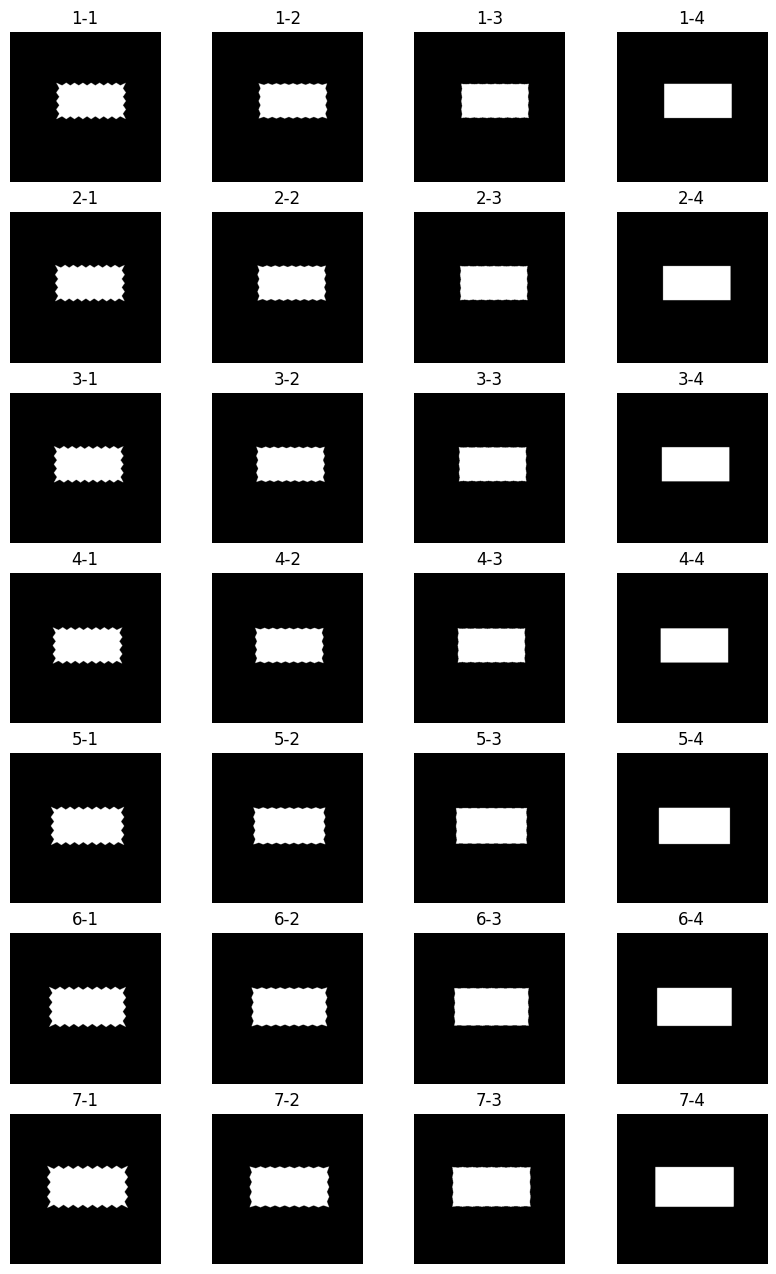

In [48]:
n_rows, n_cols = 7, 4
fig = plt.figure(figsize=(10, 16))
all_axes = []
j = 0
for i in range(len(all_paths)):
    all_axes.append(fig.add_subplot(n_rows, n_cols, i+1))

labels = []
for ax in all_axes:
    ax.axis('off')
    title = '{}-{}'.format(all_paths[j][-7], all_paths[j][-5])
    labels.append(title)
    ax.set_title(title, fontsize= 12)
    ax.imshow(all_masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [49]:
ref_idx = 12   # index of reference object (i.e. ground truth)
gt = all_masks[ref_idx]

In [50]:
mce = []
mce_no_edge = []
ious = []
miou = []
iou = IoU()
for i, mask in enumerate(all_masks):
    mce_gt_mask = MCE(gt, mask)
    mce.append(mce_gt_mask)
    mce_gt_mask_no_edges = MCE(gt, mask, detect_edges=False)
    mce_no_edge.append(mce_gt_mask_no_edges)
    print(f'index: {i}')
    print(f'mce_gt_mask: {mce_gt_mask}')
    # print(f'mce_gt_mask: {mce_gt_mask_no_edges}')
    print('------------------------')
    ious.append(iou.measure(gt, mask))
    miou.append(miou_obj.measure(gt, mask))
measures_list=[ious, miou, mce]

distance: 1.718902587890625
distance: 2.5665283203125
distance: 3.96728515625
distance: 5.0537109375
distance: 5.2734375
distance: 4.6875
distance: 7.8125
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.1793), tensor(0.0768), tensor(0.0189), tensor(0.0064), tensor(0.0051), tensor(0.0092), tensor(0.0004), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.707407951907322


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


distance: 2.978515625
distance: 3.0120849609375
distance: 3.1005859375
distance: 3.0517578125
distance: 2.63671875
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.0509), tensor(0.0492), tensor(0.0450), tensor(0.0473), tensor(0.0716), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7179849844517224
index: 0
mce_gt_mask: 0.707407951907322
------------------------


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


distance: 1.5895843505859375
distance: 2.3712158203125
distance: 3.77197265625
distance: 4.98046875
distance: 4.6875
distance: 5.859375
distance: 9.375
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.2040), tensor(0.0934), tensor(0.0230), tensor(0.0069), tensor(0.0092), tensor(0.0029), tensor(8.4818e-05), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7070640664165013
distance: 2.9560089111328125
distance: 2.99530029296875
distance: 3.0517578125
distance: 3.0029296875
distance: 2.34375
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.0520), tensor(0.0500), tensor(0.0473), tensor(0.0496), tensor(0.0960), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.718176702438068
index: 1
mce_gt_mask: 0.7070640664165013
------------------------
distance: 1.461029052734375
distance: 2.20184326171875
distance: 3.5888671875
distance: 5.3466796875
distance: 4.78515625
distance: 5.859375
distance: 9.

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 2.997589111328125
distance: 3.021240234375
distance: 3.045654296875
distance: 3.3447265625
distance: 3.02734375
distance: 3.90625
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.0499), tensor(0.0487), tensor(0.0476), tensor(0.0353), tensor(0.0484), tensor(0.0201), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.709064579223995
index: 2
mce_gt_mask: 0.7071045879318414
------------------------


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


distance: 1.3866424560546875
distance: 1.898193359375
distance: 3.265380859375
distance: 5.2734375
distance: 4.58984375
distance: 5.859375
distance: 9.375
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.2499), tensor(0.1498), tensor(0.0382), tensor(0.0051), tensor(0.0102), tensor(0.0029), tensor(8.4818e-05), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7073098081608831
distance: 2.9956817626953125
distance: 3.06549072265625
distance: 3.363037109375
distance: 3.3447265625
distance: 3.02734375
distance: 3.90625
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.0500), tensor(0.0466), tensor(0.0346), tensor(0.0353), tensor(0.0484), tensor(0.0201), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7090363043854503
index: 3
mce_gt_mask: 0.7073098081608831
------------------------
distance: 1.665496826171875
distance: 2.3193359375
distance: 3.1982421875
distance: 4.00390625
distance: 4.00390625
distance: 4.6875
distance: 7.

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 1.5743255615234375
distance: 2.2735595703125
distance: 3.21044921875
distance: 3.8330078125
distance: 3.90625
distance: 4.6875
distance: 7.8125
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.2071), tensor(0.1029), tensor(0.0403), tensor(0.0216), tensor(0.0201), tensor(0.0092), tensor(0.0004), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.70791124311376
distance: 2.0122528076171875
distance: 2.04010009765625
distance: 2.06298828125
distance: 1.9775390625
distance: 2.1484375
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.1337), tensor(0.1300), tensor(0.1271), tensor(0.1384), tensor(0.1167), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7203309978728605
index: 5
mce_gt_mask: 0.70791124311376
------------------------
distance: 1.46026611328125
distance: 2.19268798828125
distance: 3.22265625
distance: 3.466796875
distance: 3.61328125
distance: 4.296875
distance: 7.8125
d

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.1325), tensor(0.1246), tensor(0.0931), tensor(0.0960), tensor(0.1058), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7194459228308181
index: 7
mce_gt_mask: 0.7076756955749639
------------------------
distance: 1.34429931640625
distance: 1.739501953125
distance: 2.0751953125
distance: 1.7822265625
distance: 1.26953125
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.2607), tensor(0.1756), tensor(0.1255), tensor(0.1683), tensor(0.2810), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7220198428400639
distance: 1.06201171875
distance: 1.07421875
distance: 1.08642578125
distance: 0.8544921875
distance: 0.68359375
distance: 1.5625
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.3458), tensor(0.3416), tensor(0.3374), tensor(0.4255), tensor(0.5048), tensor(0.2

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 1.21307373046875
distance: 1.58538818359375
distance: 2.0263671875
distance: 2.2216796875
distance: 2.83203125
distance: 2.34375
distance: 3.125
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.2973), tensor(0.2049), tensor(0.1318), tensor(0.1084), tensor(0.0589), tensor(0.0960), tensor(0.0439), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.8878559545192817
distance: 1.0467529296875
distance: 1.0498046875
distance: 1.031494140625
distance: 1.2451171875
distance: 1.46484375
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.3511), tensor(0.3500), tensor(0.3565), tensor(0.2879), tensor(0.2311), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.9791377218997874
index: 10
mce_gt_mask: 0.8878559545192817
------------------------
distance: 1.1402130126953125
distance: 1.4404296875
distance: 2.154541015625
distance: 2.001953125
distance: 2.83203125
distance: 2.34375
distance: 3.125
distance: 0.0
distance: 0.0
distan

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 0.0
distance: 0.0
distances: [tensor(0.7712), tensor(0.7751), tensor(0.8027), tensor(0.8027), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.9952457355309838
index: 13
mce_gt_mask: 0.9928634854037234
------------------------


/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


distance: 0.937652587890625
distance: 1.06658935546875
distance: 1.08642578125
distance: 0.9765625
distance: 1.171875
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.3915), tensor(0.3442), tensor(0.3374), tensor(0.3766), tensor(0.3098), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.981108138735047
distance: 0.49591064453125
distance: 0.4608154296875
distance: 0.433349609375
distance: 0.3173828125
distance: 0.1953125
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.6090), tensor(0.6308), tensor(0.6483), tensor(0.7281), tensor(0.8226), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.9920267740632689
index: 14
mce_gt_mask: 0.981108138735047
------------------------
distance: 1.0196685791015625
distance: 1.28173828125
distance: 1.470947265625
distance: 1.6845703125
distance: 2.44140625
distance: 2.34375
distance: 3.125
distance: 0.0
distance: 0.0
distance: 0.0
distan

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 1.4423370361328125
distance: 1.88446044921875
distance: 2.197265625
distance: 2.4658203125
distance: 2.9296875
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.2364), tensor(0.1519), tensor(0.1111), tensor(0.0849), tensor(0.0534), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.719090877867772
distance: 1.1016845703125
distance: 1.12762451171875
distance: 1.153564453125
distance: 1.3427734375
distance: 1.3671875
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.3323), tensor(0.3238), tensor(0.3155), tensor(0.2611), tensor(0.2548), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7244331774384022
index: 16
mce_gt_mask: 0.719090877867772
------------------------
distance: 1.3519287109375
distance: 1.8096923828125
distance: 2.20947265625
distance: 2.44140625
distance: 2.83203125
distance: 1.953125
distance: 4.68

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

mce: 0.9839491865318815
index: 18
mce_gt_mask: 0.887490489893755
------------------------
distance: 1.2821197509765625
distance: 1.8707275390625
distance: 2.490234375
distance: 3.173828125
distance: 4.00390625
distance: 2.34375
distance: 3.125
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.2774), tensor(0.1540), tensor(0.0829), tensor(0.0418), tensor(0.0182), tensor(0.0960), tensor(0.0439), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.8861488705854534
distance: 1.497650146484375
distance: 1.4129638671875
distance: 1.0986328125
distance: 0.830078125
distance: 0.87890625
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distance: 0.0
distances: [tensor(0.2237), tensor(0.2434), tensor(0.3333), tensor(0.4360), tensor(0.4152), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
mce: 0.9823239511006499
index: 19
mce_gt_mask: 0.8861488705854534
------------------------
distance: 1.6815185546875
distance: 2.392578125
distance: 3.50341796875
distance: 4.638671875
dis

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 1.5964508056640625
distance: 2.2796630859375
distance: 3.43017578125
distance: 4.58984375
distance: 5.17578125
distance: 4.296875
distance: 7.8125
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.2026), tensor(0.1023), tensor(0.0324), tensor(0.0102), tensor(0.0057), tensor(0.0136), tensor(0.0004), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7079195980258911
distance: 2.2064208984375
distance: 2.2064208984375
distance: 2.1484375
distance: 2.1240234375
distance: 1.7578125
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.1101), tensor(0.1101), tensor(0.1167), tensor(0.1195), tensor(0.1724), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.720223167318497
index: 21
mce_gt_mask: 0.7079195980258911
------------------------
distance: 1.4652252197265625
distance: 2.09503173828125
distance: 3.179931640625
distance: 4.638671875
distance: 5.56640625
distance: 5.46875
distance: 9.37

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 2.61383056640625
distance: 2.55279541015625
distance: 2.410888671875
distance: 2.001953125
distance: 1.7578125
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.0733), tensor(0.0779), tensor(0.0897), tensor(0.1351), tensor(0.1724), tensor(0.1418), tensor(0.0092), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7203151003605412
index: 23
mce_gt_mask: 0.7072896037719218
------------------------
distance: 1.82342529296875
distance: 2.67333984375
distance: 4.119873046875
distance: 6.201171875
distance: 7.6171875
distance: 11.328125
distance: 23.4375
distance: 25.0
distance: 0.0
distance: 0.0
distances: [tensor(0.1615), tensor(0.0690), tensor(0.0162), tensor(0.0020), tensor(0.0005), tensor(1.2030e-05), tensor(6.6256e-11), tensor(1.3888e-11), tensor(1.), tensor(1.)]
mce: 0.7066076793061589
distance: 3.4076690673828125
distance: 3.4454345703125
distance: 3.5400390625
distance: 3.7841796875
distance: 3.22265625
distance: 7.8125
dis

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distance: 3.2958984375
distance: 1.953125
distance: 2.734375
distance: 6.25
distance: 18.75
distance: 0.0
distance: 0.0
distances: [tensor(0.0321), tensor(0.0320), tensor(0.0336), tensor(0.0370), tensor(0.1418), tensor(0.0649), tensor(0.0019), tensor(7.1941e-09), tensor(1.), tensor(1.)]
mce: 0.7125357705412483
index: 25
mce_gt_mask: 0.7066579761313243
------------------------
distance: 1.5583038330078125
distance: 2.3468017578125
distance: 3.82080078125
distance: 5.4443359375
distance: 5.56640625
distance: 5.46875
distance: 9.375
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.2105), tensor(0.0957), tensor(0.0219), tensor(0.0043), tensor(0.0038), tensor(0.0042), tensor(8.4818e-05), tensor(3.7267e-06), tensor(1.), tensor(1.)]
mce: 0.7070921428122582
distance: 3.4519195556640625
distance: 3.4088134765625
distance: 3.326416015625
distance: 3.173828125
distance: 1.7578125
distance: 1.953125
distance: 4.6875
distance: 12.5
distance: 0.0
distance: 0.0
distances: [tensor(0.031

/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_21951/3604676800.py:5: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


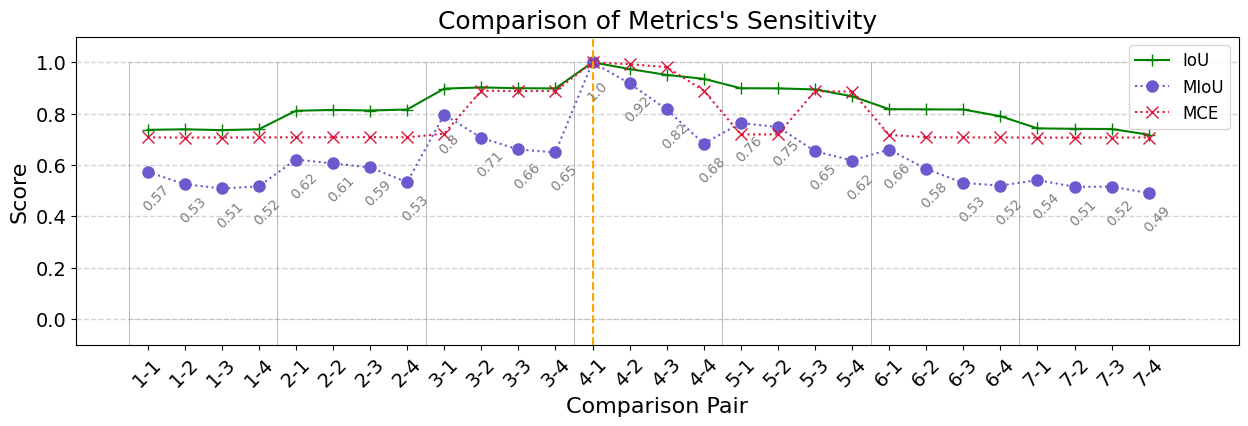

In [51]:
x = np.arange(0, len(all_masks), dtype=int)
areas_c = list(1 - np.array(miou))
areas_c = miou
plots = []
colors = ['green', 'slateblue', 'crimson', 'slateblue', 'crimson']
legend_labels = ['IoU', 'MIoU','MCE']
labels = ['{}-{}'.format(i,j) for i in range(1, n_rows+1) for j in range(1,n_cols+1)]
markers = ['+', 'o', 'x', '1', 's']
linestyles = ['solid', 'dotted', 'dotted', 'solid', 'solid']

ymin = -0.1
ymax = max([max(measures) for measures in measures_list])

fig, ax = plt.subplots(figsize=(15, 4))
for i, measures in enumerate(measures_list):
    plots.append(plt.plot(x, measures,
                          color=colors[i], linestyle=linestyles[i], linewidth=1.5,
                          marker=markers[i], markersize=8,  label=legend_labels[i]))    

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.grid(axis='y', which='both', color='lightgray', linestyle='--', linewidth=1)
plt.ylim(ymin, ymax + 0.1)
plt.vlines(ref_idx, ymin=ymin, ymax=ymax + 0.1, colors='orange', linestyles='--', label='GT')
plt.vlines(x[::4]-0.5, ymin=ymin, ymax=ymax, colors='gray', linestyles='solid', lw=0.4)
plt.hlines(y=0.0, xmin=-0.5, xmax=len(all_masks), colors='gray', linestyles=':', lw=0.4)
plt.hlines(y=1.0, xmin=-0.5, xmax=len(all_masks), colors='gray', linestyles=':', lw=0.4)
plt.title("Comparison of Metrics's Sensitivity", fontsize=18)
plt.xlabel('Comparison Pair', fontsize=16)
plt.ylabel('Score', fontsize=16)


for i in np.arange(len(all_masks)):
    ax.annotate(np.round(areas_c[i], 2), (x[i]-0.2, areas_c[i] - 0.15), color='gray', rotation=45)

plt.legend(legend_labels, fontsize=12)
plt.show()

In [52]:
print(mce)
print(mce_gt_mask_no_edges)

[0.707407951907322, 0.7070640664165013, 0.7071045879318414, 0.7073098081608831, 0.7078208150142717, 0.70791124311376, 0.7084675757361323, 0.7076756955749639, 0.7220198428400639, 0.8899053079303929, 0.8878559545192817, 0.8884426697855359, 1.0, 0.9928634854037234, 0.981108138735047, 0.8898427962104984, 0.719090877867772, 0.7192099688994038, 0.887490489893755, 0.8861488705854534, 0.7171319870488013, 0.7079195980258911, 0.7073358578310431, 0.7072896037719218, 0.7066076793061589, 0.7066579761313243, 0.7070921428122582, 0.7070842386707329]
0.7180484914556399


In [53]:
print(np.var(mce))

0.010651875958468294


In [48]:
# Code structure

In [ ]:
def pre_process_masks(mask1, mask2, scale):  # This is the function s in the paper
    # Superimpose a grid over gt and prediction
    return s1, s2

In [ ]:
def pre_process_masks(mask1, mask2, scale):  # This is the function s in the paper
    preprocessor1 = GridBasedSegmentation(mask1, scale)
    s1 = preprocessor1.segmentize()
    preprocessor2 = GridBasedSegmentation(mask2, scale)
    s2 = preprocessor2.segmentize()

    return s1, s2

In [ ]:
def calculate_bce_with_logits(gt, prediction):
    # calculate Cross Entropy in 1 resolution
    return loss

In [ ]:
def calculate_bce_with_logits(gt, prediction, scale):
    # return custom_bce_simplified(gt, prediction)
    # print(prediction)
    # print(gt)
    loss = nn.BCEWithLogitsLoss()
    l = loss(prediction, gt)
    print(l)
    print("-------------------------------------------------------------")
    return l

In [ ]:
def calculate_area(distances, scales):
    # Given the distances (y-coordinates) and scales (x-coordinates) 
    # calculate the area under this curve
    # And normalize scales between [0.1] first
    return area

In [ ]:
def calculate_area(distances, scales):
    # normalized_boxsizes = miou.normalize_boxsizes(scales)
    # slope, _, _, _, _ = linregress(normalized_boxsizes, distances)
    # aiou = np.abs(slope)
    #
    # area = miou.integral_trapezoidal(distances, dx=1 / (len(scales) - 1))
    sd = np.std(scales)
    mean = np.mean(scales)
    normalized_scales = (scales-mean)/sd
    area = simpson(distances, normalized_scales)
    return area

In [ ]:
def MCE(gt, img2, detect_edges = True):

    if detect_edges:
        # Apply filter to only work with edges of the masks
        
    for scale in scales:
        # preprocess gt and prediction masks
        s_gt, s_img2 = pre_process_masks(gt, img2, scale)
        # calculate Cross Entropy (distance between gt and prediction)
        distance = calculate_bce_with_logits(
            torch.tensor(s_gt, dtype=torch.float),
            torch.tensor(s_img2, dtype=torch.float),
            scale)
        distances.append(distance)

    # normalize scales and calculate the area under the curve
    mce = calculate_area(distances, scales)
    return mce

